In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt

In [ ]:
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

In [ ]:
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

from keras.metrics import MeanIoU

In [ ]:
# Google Drive Integration
from google.colab import drive
drive.mount('/content/drive')


SIZE = 256
root_path = '/content/drive/MyDrive/Breast_Cancer_MRI_2/'
classes = ['benign', 'malignant', 'normal']

Mounted at /content/drive


In [ ]:
def load_image(image, SIZE): #for loading and processing just a single image, where image is resized and normalized
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

def load_images(image_paths, SIZE, mask=False, trim=None): #for loading and processing multiple images at once, depending on the trim. if trim=5, 5 img processed at once.
    if trim is not None:
        image_paths = image_paths[:trim]
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1)) #for mask, just one channel.
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3)) #for full RGB image of the same.
    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [ ]:
def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [ ]:
single_mask_paths = [sorted(glob(root_path + cls + '/*_mask.png')) for cls in classes]
'''
in the above line, we get the mask path of each folder we have in the drive.
'''
image_paths = []
mask_paths = []
'''
in the single mask path, we have paths to each and every mask from the folders. as in, as we have 3 folders, malignant, benign and normal, the single_mask_paths will have 3
sublists wherein in each sublist, we have the path to the binary mask.
'''
for class_path in single_mask_paths: #each sublist (3 folders we have), is iterated one by one.
    for path in class_path: #for each binary mask path we have inside that sublist, we are just getting the corresponding image path by just removing 'mask' word from the mask path.
        img_path = path.replace('_mask', '')
        image_paths.append(img_path) #contains all the images paths.
        mask_paths.append(path) #contains all the corresponding masks paths .

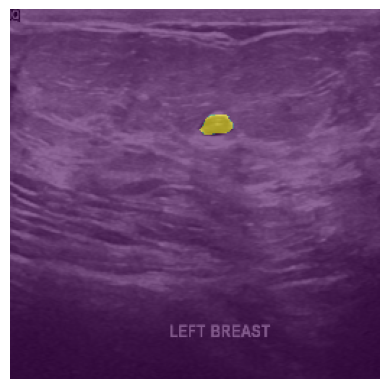

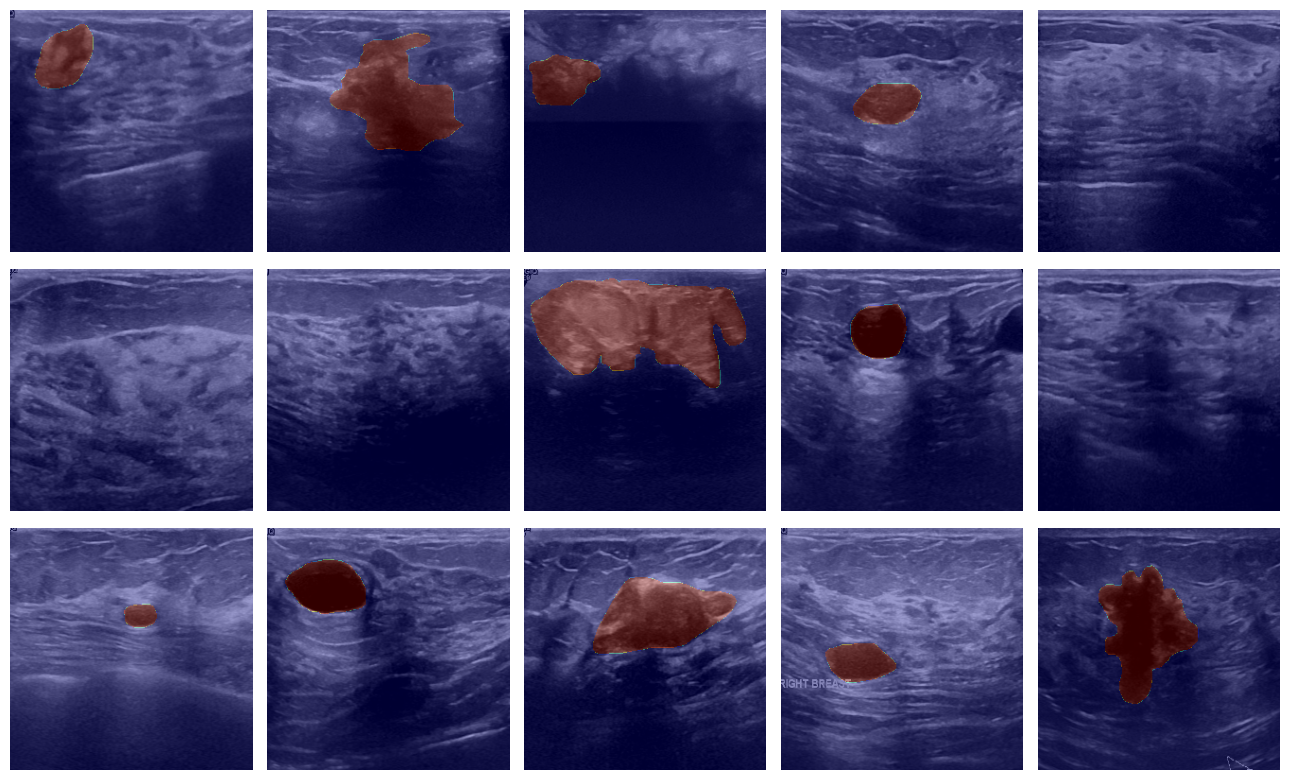

In [ ]:
show_image(load_image(image_paths[0], SIZE)) #loads just a single image and resizes it and is displayed.
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:, :, 0], alpha=0.6) #loads the mask of corresponding image, resized and is displayed on top of image.

images = load_images(image_paths, SIZE) #loads all images.
masks = load_images(mask_paths, SIZE, mask=True) #loads all the corresponding masks.

plt.figure(figsize=(13, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

In [ ]:
# Encoder Block
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters #number of filters
        self.rate = rate #dropout layer rate
        self.pooling = pooling #pooling to keep or not, hence its a boolean
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        '''
        he_normal is the weight initializer of the filter (kernel), where all the weights belong to normal distribution, having mean=0, and this technique used as we are using
        RELU as the activation function to prevent the dying neuron problem (giving o/p=0 consistently)
        '''
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()
    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling: #if pooling = true, do pooling and return y as well as x for skip connection.
            y = self.pool(x)
            return y, x #x goes as the feature map for the next layer and the y is feeded as the skip connection.
        else:
            return x #pooling not done and x feeded as the feature map for the next downsampling.
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters": self.filters, 'rate': self.rate, 'pooling': self.pooling}

In [ ]:
# Decoder Block
class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        #after upsampling, we repeat the whole process of the Encoder block, except for the max pooling.
        '''
        convolution layers applied again in order to enhance the features we got from upsampling the feature map, without reducing its spatial dimensions.
        '''
        self.net = EncoderBlock(filters, rate, pooling=False)
    def call(self, X):
        X, skip_X = X #2 copies of X are stored inside X and skip_X.
        x = self.up(X)#1 copy stored in X upsamples the X
        c_ = concatenate([x, skip_X])#skip connection done.
        x = self.net(c_)
        return x
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters": self.filters, 'rate': self.rate}

In [ ]:
# Attention Gate
class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters
        self.bn = bn #outputs of activations normalized to have mean 0 and std dv 1 so that inputs to next layers are more consistent.
        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal') #normal conv applied to X
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal') #down sampling applied to skip_X
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid') #1X1 filter conv focussing on certain areas of feature map
        self.resample = UpSampling2D() #restoring spatial resolution of the mask
        self.BN = BatchNormalization() #if bn=true, Batch Norm done.
    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters": self.filters, "bn": self.bn}

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):

        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [ ]:
# Build Attention U-Net
input_layer = Input(shape=images.shape[-3:])
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)
encoding = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256, 0.2, name="Decoder1")([encoding, a1])
a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128, 0.2, name="Decoder2")([d1, a2])
a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64, 0.1, name="Decoder3")([d2, a3])
a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32, 0.1, name="Decoder4")([d3, a4])
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

In [ ]:
# Compile model
model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', MeanIoU(num_classes=2)])

In [ ]:
# Callbacks
cb = [

    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]


In [ ]:
# Train model
BATCH_SIZE = 8
SPE = len(images) // BATCH_SIZE
results = model.fit(images, masks, validation_split=0.2, epochs=100, steps_per_epoch=SPE, batch_size=BATCH_SIZE)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 256, 256, 3))
  warnings.warn(msg)


78/97 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.8742 - loss: 0.4160 - mean_io_u: 0.4569

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


97/97 ━━━━━━━━━━━━━━━━━━━━ 88s 357ms/step - accuracy: 0.8791 - loss: 0.3988 - mean_io_u: 0.4565 - val_accuracy: 0.9813 - val_loss: 0.3524 - val_mean_io_u: 0.4909
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.9125 - loss: 0.2384 - mean_io_u: 0.4564 - val_accuracy: 0.9813 - val_loss: 0.3241 - val_mean_io_u: 0.4909
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 0.9156 - loss: 0.2280 - mean_io_u: 0.4541 - val_accuracy: 0.9812 - val_loss: 0.1922 - val_mean_io_u: 0.4909
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.9227 - loss: 0.2119 - mean_io_u: 0.4559 - val_accuracy: 0.9813 - val_loss: 0.0925 - val_mean_io_u: 0.4909
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9226 - loss: 0.2068 - mean_io_u: 0.4535 - val_accuracy: 0.9814 - val_loss: 0.1073 - val_mean_io_u: 0.4909
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.9239 - loss: 0.2032 - mean_io_u: 0.4542 - val_accuracy: 0.9749 - val_loss:

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

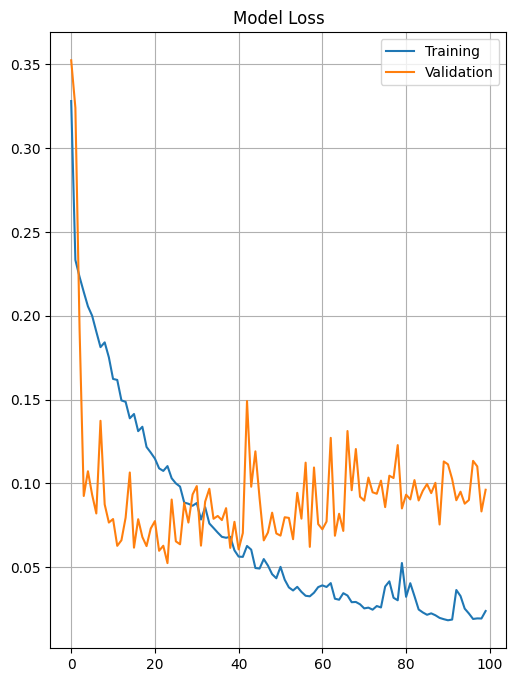

In [ ]:
# Plot training results
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.title("Model Loss")
plt.plot(results.history['loss'], label="Training")
plt.plot(results.history['val_loss'], label="Validation")
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

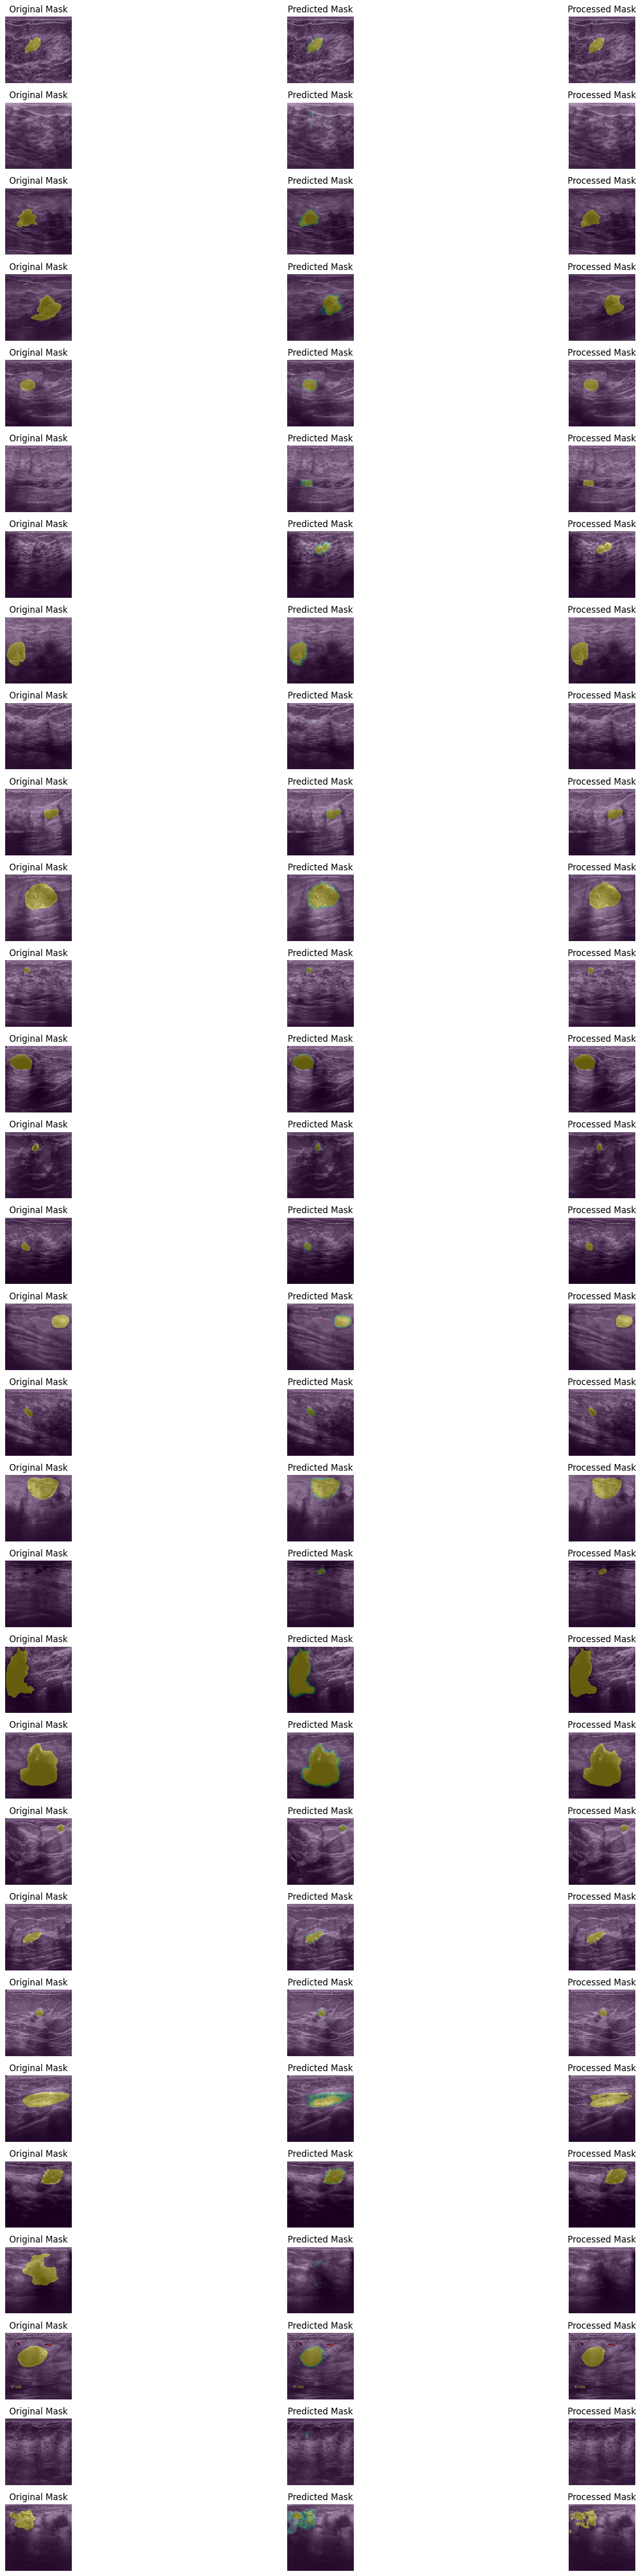

In [ ]:
plt.figure(figsize=(20,50))
n=0
for i in range(1,(30*3)+1):
    plt.subplot(30,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('BCSEG.h5')